In [1]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy 
from PIL import Image
from scipy import ndimage

In [3]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0)  #set default size for plot
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap']='gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

In [4]:
def load_data():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) #train set
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) #train set label
    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) #test set
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) #test set labels
    
    classes = np.array(test_dataset["list_classes"][:]) # list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [8]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

y = 0. It's a non-cat picture.


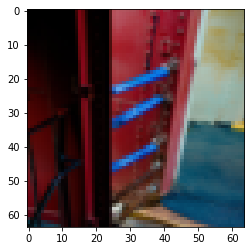

In [10]:
index = 45
plt.imshow(train_x_orig[index])
print("y = " + str(train_y[0, index]) + ". It's a " + classes[train_y[0, index]].decode("utf-8") + " picture.")

In [9]:
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


In [11]:
#Reshap
# -1 makes reshape flatten the remaining dimensions
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T
test_x_flatten =  test_x_orig.reshape(test_x_orig.shape[0], -1).T

#standardize the data to have values between 0 and 1
train_x = train_x_flatten/255.
test_x = test_x_flatten/255

print("train_x's shape: " + str(train_x.shape))
print("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


## 2 layer NN

In [12]:
def initialize_parameters(n_x, n_h, n_y):
    np.random.seed(1)
    
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters
    

In [17]:
def sigmoid(Z):
    
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache    

In [18]:
def relu(Z):
    
    A = np.maximum(0,Z)
    cache = Z
    
    return A, cache

In [19]:
def sigmoid_backward(dA, cache):
    
    Z = cache
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    return dZ

In [20]:
def relu_backward(dA, cache):
    
    Z = cache
    dZ = np.array(dA, copy=True) #just converting dZ tp correct object
    
    #when z <= 0 set dZ to 0
    dZ[dZ <= 0] = 0
    
    return dZ

In [16]:
def linear_forward(A, W, b):
    Z = W.dot(A) + b
    cache = (A, W, b)
    return Z, cache

In [38]:
def linear_activation_forward(A_prev, W, b, activation):
    
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
        
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
        
    cache = (linear_cache, activation_cache)
    return A, cache

In [22]:
def compute_cost(AL, Y):
    
    m = Y.shape[1]
    
    #compute loss from aL and y
    cost = (1./m) *  (-np.dot(Y, np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
    # to make cost shape as expecte [[17]] --> 17
    cost = np.squeeze(cost)
    
    return cost

In [57]:
def linear_backward(dZ, cache):
    
    A_prev, W, b = cache
    m = A_prev.shape[1]
    
    dW = 1./m * np.dot(dZ, A_prev.T)
    db = 1./m * np.sum(dZ, axis = 1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)
    
    return dA_prev, dW, db

In [23]:
def linear_activation_backward(dA, cache, activation):
    
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    return dA_prev, dW, db

In [62]:
def L_model_forward(X, parameters):
    
    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)
    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "sigmoid")
    caches.append(cache)
    
    
            
    return AL, caches

In [47]:
def update_parameters(parameters, grads, learning_rate):
    
    L = len(parameters) // 2 
    
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        
    return parameters

In [67]:
def predict(X, y, parameters):
    
    m = X.shape[1]
    n = len(parameters) // 2 
    p = np.zeros((1,m))
    
    #forward_prop
    probas, caches = L_model_forward(X, parameters)
    
    #convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0, 1] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
        
    print("Accuracy: " + str(np.sum((p == y)/m)))
    
    return p
            

In [25]:
n_x = 12288
n_y = 1
n_h = 7
layers_dims = (n_x, n_h, n_y)

In [58]:
def two_layer_model(X, Y, layers_dims, learning_rate= 0.0075, num_iterations = 3000, print_cost=False):
    
    np.random.seed(1)
    grads = {}
    costs = []
    m = X.shape[1]
    (n_x, n_h, n_y) = layers_dims
    
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    #gradient descent
    for i in range(0, num_iterations):
        #forward_propogation
        A1, cache1 = linear_activation_forward(X, W1, b1, activation="relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, activation="sigmoid")
        
        #compute cost
        cost = compute_cost(A2, Y)
        
        #initializing backward propagation
        dA2 = -(np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        #backward propogation
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, activation="sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, activation="relu")
        
        #set grads
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        #update parameters
        parameters = update_parameters(parameters, grads, learning_rate=learning_rate)
        
        #retrieve W1, b1, W2, b2
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        #print cost for every 100 training  example
        if print_cost  and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    #plot cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundereds)')
    plt.title("Learning  rate =" + str(learning_rate))
    plt.show()
        
    return parameters

Cost after iteration 0: 0.6930497356599888
Cost after iteration 100: 0.6780427979236924
Cost after iteration 200: 0.6676252596606437
Cost after iteration 300: 0.6604401142583466
Cost after iteration 400: 0.6554705019856955
Cost after iteration 500: 0.6520223136074352
Cost after iteration 600: 0.6496220161980254
Cost after iteration 700: 0.6479460901464308
Cost after iteration 800: 0.6467727060375958
Cost after iteration 900: 0.6459491542488462
Cost after iteration 1000: 0.6453698878592302
Cost after iteration 1100: 0.644961679846815
Cost after iteration 1200: 0.6446735486559289
Cost after iteration 1300: 0.6444698884839578
Cost after iteration 1400: 0.6443257625103379
Cost after iteration 1500: 0.6442236631515749
Cost after iteration 1600: 0.6441512724459171
Cost after iteration 1700: 0.644099907700378
Cost after iteration 1800: 0.6440634388958404
Cost after iteration 1900: 0.644037532290901
Cost after iteration 2000: 0.6440191204723126
Cost after iteration 2100: 0.6440060301616181
Cos

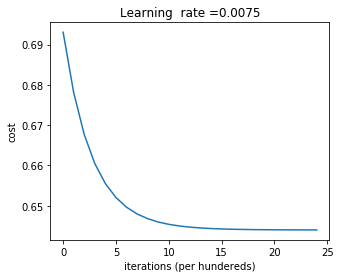

In [59]:
parameters = two_layer_model(train_x, train_y, layers_dims  = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)

In [68]:
prediction_train = predict(train_x, train_y, parameters)

Accuracy: 0.6555023923444976


In [69]:
predictions_test = predict(test_x, test_y, parameters)

Accuracy: 0.3400000000000001
